# **1. Data Preprocessing**

## 1.1 Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


: 

In [2]:
dataset = pd.read_csv('NSL_KDD.csv')
train_df, test_df = train_test_split(dataset, test_size = 0.2, random_state = 1)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nAvailable features: {train_df.shape[1]}")

Training set shape: (100778, 43)
Test set shape: (25195, 43)

Available features: 43


## 1.3 Enhanced Feature Selection


In [3]:
enhanced_features = [
    # Basic connection features
    "duration", "protocol_type", "service", "flag",
    "src_bytes", "dst_bytes",

    # Connection-based features
    "land", "wrong_fragment", "urgent",

    # Content-based features (detect privilege escalation)
    "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files",

    # Traffic-based features (detect scanning/probing)
    "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate",

    # Host-based traffic features (detect DoS/DDoS)
    "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate",

    "label"
]

train_df = train_df[enhanced_features]
test_df = test_df[enhanced_features]

print(f"Using {len(enhanced_features) - 1} features")
print(f"\nFeature categories:")
print("  - Basic: 6 features")
print("  - Connection: 3 features")
print("  - Content: 10 features")
print("  - Traffic: 9 features")
print("  - Host-based: 10 features")

Using 38 features

Feature categories:
  - Basic: 6 features
  - Connection: 3 features
  - Content: 10 features
  - Traffic: 9 features
  - Host-based: 10 features


## 1.4 Data Exploration

Label Distribution in Training Set:
label
normal             53837
neptune            33041
satan               2878
ipsweep             2871
portsweep           2380
smurf               2098
nmap                1182
back                 787
teardrop             705
warezclient          702
pod                  165
guess_passwd          35
buffer_overflow       22
warezmaster           17
land                  15
imap                   9
loadmodule             8
ftp_write              7
rootkit                7
multihop               5
phf                    3
spy                    2
perl                   2
Name: count, dtype: int64

Binary Classification:
Training - Benign: 53837, Malicious: 46941
Test - Benign: 13506, Malicious: 11689


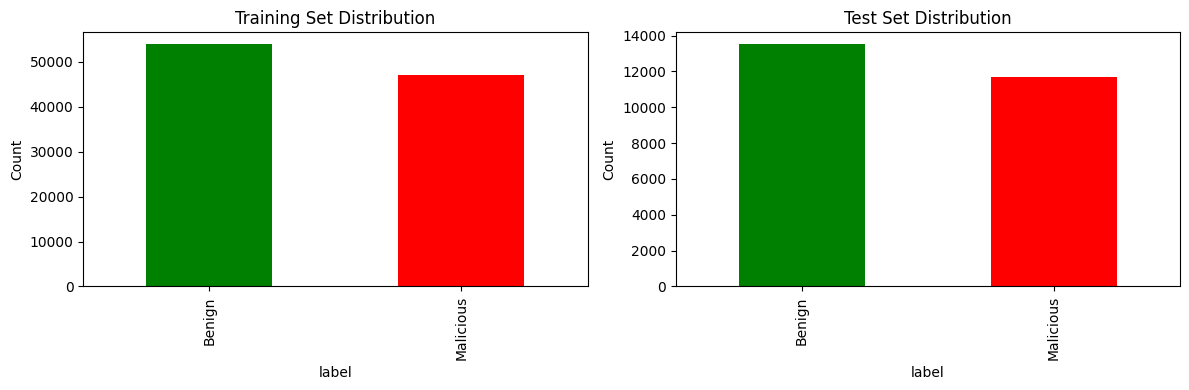

In [4]:
# Check class distribution
print("Label Distribution in Training Set:")
print(train_df['label'].value_counts())

# Binary classification
train_benign = (train_df['label'] == 'normal').sum()
train_malicious = (train_df['label'] != 'normal').sum()
test_benign = (test_df['label'] == 'normal').sum()
test_malicious = (test_df['label'] != 'normal').sum()

print(f"\nBinary Classification:")
print(f"Training - Benign: {train_benign}, Malicious: {train_malicious}")
print(f"Test - Benign: {test_benign}, Malicious: {test_malicious}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
train_df['label'].apply(lambda x: 'Benign' if x == 'normal' else 'Malicious').value_counts().plot(
    kind='bar', ax=axes[0], color=['green', 'red']
)
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Count')

test_df['label'].apply(lambda x: 'Benign' if x == 'normal' else 'Malicious').value_counts().plot(
    kind='bar', ax=axes[1], color=['green', 'red']
)
axes[1].set_title('Test Set Distribution')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

## 1.5 Encode Labels

In [5]:
# Binary encoding: 0 = benign, 1 = malicious
train_df["label"] = train_df["label"].apply(lambda x: 0 if x == "normal" else 1)
test_df["label"] = test_df["label"].apply(lambda x: 0 if x == "normal" else 1)

print("Labels encoded successfully!")
print(f"0 = Benign, 1 = Malicious")

Labels encoded successfully!
0 = Benign, 1 = Malicious


## 1.6 Separate Features and Labels

In [6]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (100778, 38)
X_test shape: (25195, 38)


## 1.7 Encode Categorical Variables

In [7]:
# Categorical features: protocol_type, service, flag
categorical_features = ["protocol_type", "service", "flag"]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

print(f"Categorical features encoded: {X_train_cat.shape[1]} columns created")

Categorical features encoded: 84 columns created


## 1.8 Feature Scaling

In [8]:
# Numeric features (all except categorical)
numeric_features = [col for col in X_train.columns if col not in categorical_features]

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

print(f"Numeric features scaled: {len(numeric_features)} features")

Numeric features scaled: 35 features


## 1.9 Combine Features

In [9]:
X_train_final = np.hstack((X_train_num, X_train_cat))
X_test_final = np.hstack((X_test_num, X_test_cat))

print(f"Final feature vector size: {X_train_final.shape[1]} features")
print(f"Training samples: {X_train_final.shape[0]}")
print(f"Test samples: {X_test_final.shape[0]}")

Final feature vector size: 119 features
Training samples: 100778
Test samples: 25195


# **2. Model Training & Comparison**

## Model 1:   Random Forest

In [11]:
rf_enhanced = RandomForestClassifier(
    n_estimators=200,         # More trees for better generalization
    max_depth=20,             # Limited depth to prevent overfitting
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
    n_jobs=-1
)

acc_rf, model_rf, proba_rf = evaluate_model(
    "ENHANCED RANDOM FOREST (200 trees, depth=20)",
    rf_enhanced, X_train_final, y_train, X_test_final, y_test
)


ENHANCED RANDOM FOREST (200 trees, depth=20)

✓ Accuracy: 0.9982
✓ AUC-ROC: 1.0000

Confusion Matrix:
                Predicted
              Benign  Malicious
Actual Benign   13495      11
    Malicious      34   11655

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9975    0.9992    0.9983     13506
   Malicious     0.9991    0.9971    0.9981     11689

    accuracy                         0.9982     25195
   macro avg     0.9983    0.9981    0.9982     25195
weighted avg     0.9982    0.9982    0.9982     25195

False Positive Rate: 0.0008
False Negative Rate: 0.0029


## Model 2: K-Nearest Neighbors

In [12]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    n_jobs=-1
)

acc_knn, model_knn, proba_knn = evaluate_model(
    "K-NEAREST NEIGHBORS (k=5)",
    knn_model, X_train_final, y_train, X_test_final, y_test
)


K-NEAREST NEIGHBORS (k=5)

✓ Accuracy: 0.9963
✓ AUC-ROC: 0.9990

Confusion Matrix:
                Predicted
              Benign  Malicious
Actual Benign   13461      45
    Malicious      49   11640

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9964    0.9967    0.9965     13506
   Malicious     0.9961    0.9958    0.9960     11689

    accuracy                         0.9963     25195
   macro avg     0.9963    0.9962    0.9962     25195
weighted avg     0.9963    0.9963    0.9963     25195

False Positive Rate: 0.0033
False Negative Rate: 0.0042


## Model 3: Linear SVM

In [13]:
# Linear SVM
from sklearn.svm import LinearSVC

svm_model = LinearSVC(
    C=1.0,
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

# LinearSVC doesn't have predict_proba
print(f"\n{'='*70}")
print("LINEAR SVM CLASSIFIER")
print('='*70)

svm_model.fit(X_train_final, y_train)
y_pred_svm = svm_model.predict(X_test_final)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc_svm = accuracy_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print(f"\n✓ Accuracy: {acc_svm:.4f}")
print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Benign  Malicious")
print(f"Actual Benign   {cm_svm[0,0]:5d}   {cm_svm[0,1]:5d}")
print(f"    Malicious   {cm_svm[1,0]:5d}   {cm_svm[1,1]:5d}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=["Benign", "Malicious"], digits=4))

model_svm = svm_model
proba_svm = None


LINEAR SVM CLASSIFIER

✓ Accuracy: 0.9754

Confusion Matrix:
                Predicted
              Benign  Malicious
Actual Benign   13273     233
    Malicious     388   11301

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9716    0.9827    0.9771     13506
   Malicious     0.9798    0.9668    0.9733     11689

    accuracy                         0.9754     25195
   macro avg     0.9757    0.9748    0.9752     25195
weighted avg     0.9754    0.9754    0.9753     25195



## Model 4: Logistic Regression (Baseline)

In [14]:
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

acc_lr, model_lr, proba_lr = evaluate_model(
    "LOGISTIC REGRESSION (Baseline)",
    lr_model, X_train_final, y_train, X_test_final, y_test
)


LOGISTIC REGRESSION (Baseline)

✓ Accuracy: 0.9748
✓ AUC-ROC: 0.9970

Confusion Matrix:
                Predicted
              Benign  Malicious
Actual Benign   13246     260
    Malicious     376   11313

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9724    0.9807    0.9766     13506
   Malicious     0.9775    0.9678    0.9727     11689

    accuracy                         0.9748     25195
   macro avg     0.9750    0.9743    0.9746     25195
weighted avg     0.9748    0.9748    0.9747     25195

False Positive Rate: 0.0193
False Negative Rate: 0.0322


# **3. Model Comparison & Analysis**

## 3.1 Accuracy Comparison

In [22]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Train and comprehensively evaluate a model"""
    print(f"\n{'='*70}")
    print(f"{name}")
    print('='*70)

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n✓ Accuracy: {accuracy:.4f}")

    if y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"✓ AUC-ROC: {auc:.4f}")

    print("\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Benign  Malicious")
    print(f"Actual Benign   {cm[0,0]:5d}   {cm[0,1]:5d}")
    print(f"    Malicious   {cm[1,0]:5d}   {cm[1,1]:5d}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"], digits=4))

    # Additional metrics
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")

    return accuracy, model, y_pred_proba

print("Evaluation function defined!")

Evaluation function defined!


In [23]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Dictionary for all models and their [redictions:
models_dict = {
    'Random Forest': model_rf,
    'K-Nearest Neighbors': model_knn,
    'Linear SVM': model_svm,
    'Logistic Regression' : model_lr
}

# Comprehensive metrics for all models
results = []

for name, model in models_dict.items():
    y_pred = model.predict(X_test_final)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')
    rec = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

# DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# Display
print("\n" + "="*80)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*80)
print("\n" + results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Highlight best model
best = results_df.iloc[0]
print("\n" + "="*80)
print("🏆 BEST MODEL")
print("="*80)
print(f"Model: {best['Model']}")
print(f"  ├─ Accuracy:  {best['Accuracy']:.4f} ({best['Accuracy']*100:.2f}%)")
print(f"  ├─ Precision: {best['Precision']:.4f}")
print(f"  ├─ Recall:    {best['Recall']:.4f}")
print(f"  └─ F1-Score:  {best['F1-Score']:.4f}")
print("="*80)


COMPREHENSIVE MODEL PERFORMANCE COMPARISON

              Model  Accuracy  Precision  Recall  F1-Score
      Random Forest    0.9982     0.9991  0.9971    0.9981
K-Nearest Neighbors    0.9963     0.9961  0.9958    0.9960
         Linear SVM    0.9754     0.9798  0.9668    0.9733
Logistic Regression    0.9748     0.9775  0.9678    0.9727

🏆 BEST MODEL
Model: Random Forest
  ├─ Accuracy:  0.9982 (99.82%)
  ├─ Precision: 0.9991
  ├─ Recall:    0.9971
  └─ F1-Score:  0.9981


## 3.2 ROC Curve (Best Model)

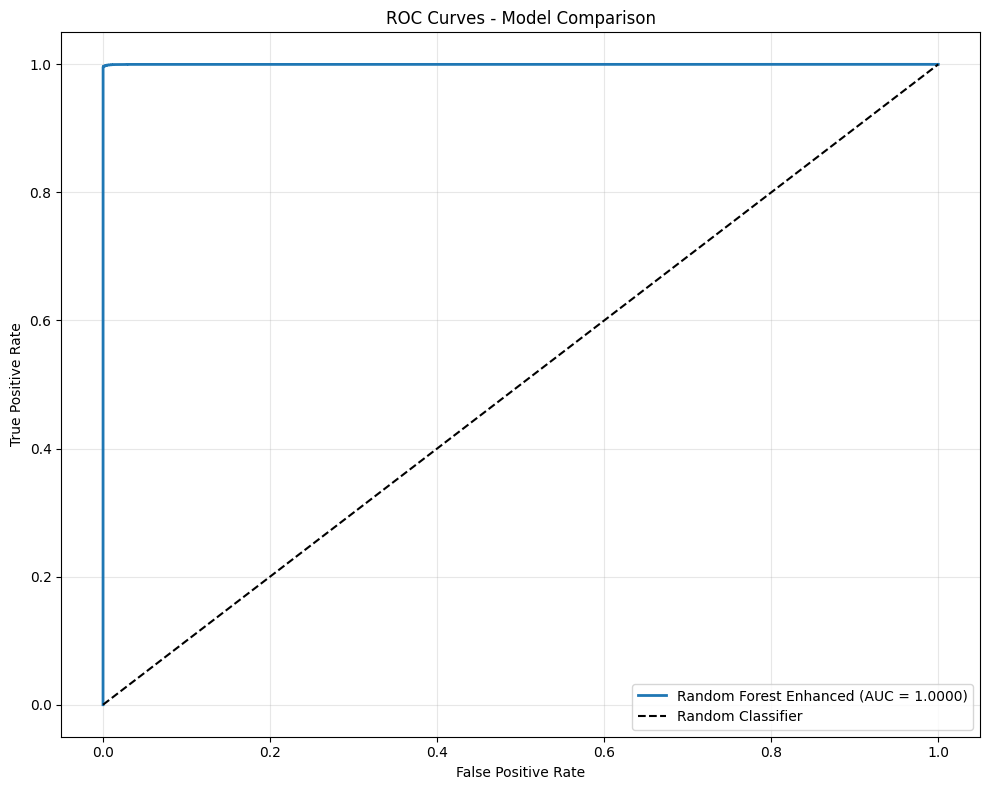

In [28]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))


# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
auc_rf = roc_auc_score(y_test, proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest Enhanced (AUC = {auc_rf:.4f})', linewidth=2)


# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()